In [2]:
import sys
sys.path.append('/nas/users/dahye/kw/tts/github_download/DeepForcedAligner')

# Preprocess

In [3]:
import argparse
from multiprocessing import cpu_count
from multiprocessing.pool import Pool
from pathlib import Path
from typing import Dict, Union

import numpy as np
import tqdm

from dfa.audio import Audio
from dfa.paths import Paths
from dfa.text import Tokenizer
from dfa.utils import get_files, read_config, pickle_binary, read_metafile
from preprocess import Preprocessor


In [4]:
class Args:
    config = '/nas/users/dahye/kw/tts/github_download/DeepForcedAligner/config.yaml'
    num_workers = cpu_count() - 1
args = Args()

In [5]:
config = read_config(args.config)
paths = Paths.from_config(config['paths'])
audio = Audio.from_config(config['audio'])
mel_dim_last = config['preprocessing']['mel_dim_last']

print(f'Config: {args.config}\n'
    f'Target data directory: {paths.data_dir}')

text_dict = read_metafile(paths.metadata_path)
symbols = set()
for text in text_dict.values():
    symbols.update(set(text))
symbols = sorted(list(symbols))

Config: /nas/users/dahye/kw/tts/github_download/DeepForcedAligner/config.yaml
Target data directory: dfa_data


In [8]:
paths.metadata_path

PosixPath('/nas/users/dahye/kw/tts/sxai/data/LJSpeech-1.1/metadata.csv')

In [17]:
if paths.precomputed_mels:
    audio_files = get_files(paths.precomputed_mels, extension='.npy')
else:
    audio_files = get_files(paths.dataset_dir, extension='.wav')

audio_files = [x for x in audio_files if x.stem in text_dict]
tokenizer = Tokenizer(symbols)
preprocessor = Preprocessor(audio=audio, tokenizer=tokenizer, paths=paths,
                            text_dict=text_dict, mel_dim_last=mel_dim_last)
pool = Pool(processes=args.num_workers)
mapper = pool.imap_unordered(preprocessor, audio_files)
dataset = []
for i, item in tqdm.tqdm(enumerate(mapper), total=len(audio_files)):
    dataset.append(item)

pickle_binary(dataset, paths.data_dir / 'dataset.pkl')
pickle_binary(symbols, paths.data_dir / 'symbols.pkl')
print('Preprocessing done.')

100%|██████████| 13100/13100 [09:18<00:00, 23.47it/s]

Preprocessing done.


# Train

In [17]:
import argparse
import torch
from torch import optim

from dfa.model import Aligner
from dfa.paths import Paths
from dfa.utils import read_config, unpickle_binary
from trainer import Trainer

In [18]:
import numpy as np
import torch
import tqdm
from torch.nn import CTCLoss
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from dfa.dataset import new_dataloader, get_longest_mel_id
from dfa.duration_extraction import extract_durations_with_dijkstra
from dfa.model import Aligner
from dfa.paths import Paths
from dfa.text import Tokenizer
from dfa.utils import to_device

In [19]:
symbols = unpickle_binary(paths.data_dir / 'symbols.pkl')

In [20]:
model_path = paths.checkpoint_dir / 'latest_model.pt'
model = Aligner(n_mels=config['audio']['n_mels'],
                num_symbols=len(symbols)+1,
                **config['model'])
optim = optim.Adam(model.parameters(), lr=1e-4)
checkpoint = {'model': model.state_dict(), 'optim': optim.state_dict(),
                'config': config, 'symbols': symbols}
trainer = Trainer(paths=paths)

In [ ]:
# trainer.train(checkpoint, train_params=config['training'])

In [21]:
self = trainer 

train_params = config['training']

lr = train_params['learning_rate']
epochs = train_params['epochs']
batch_size = train_params['batch_size']
ckpt_steps = train_params['checkpoint_steps']
plot_steps = train_params['plot_steps']

config = checkpoint['config']
symbols = checkpoint['symbols']
tokenizer = Tokenizer(symbols)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = Aligner.from_checkpoint(checkpoint).to(device)
optim = Adam(model.parameters())
optim.load_state_dict(checkpoint['optim'])

for g in optim.param_groups:
    g['lr'] = lr

dataloader = new_dataloader(dataset_path=self.paths.data_dir / 'dataset.pkl', mel_dir=self.paths.mel_dir,
    token_dir=self.paths.token_dir, batch_size=batch_size)

start_epoch = model.get_step() // len(dataloader)

In [11]:
for epoch in range(start_epoch + 1, epochs + 1):
    pbar = tqdm.tqdm(enumerate(dataloader, 1), total=len(dataloader))
    for i, batch in pbar:
        tokens, mel, tokens_len, mel_len = to_device(batch, device)

        pred = model(mel)
        pred = pred.transpose(0, 1).log_softmax(2)

        loss = self.ctc_loss(pred, tokens, mel_len, tokens_len)
        pbar.set_description(desc=f'Epoch: {epoch} | Step {model.get_step()} '
                                    f'| Loss: {loss:#.4}', refresh=True)

        if not torch.isnan(loss) and not torch.isinf(loss):
            optim.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()

        self.writer.add_scalar('CTC_Loss', loss.item(), global_step=model.get_step())
        self.writer.add_scalar('Params/batch_size', batch_size, global_step=model.get_step())
        self.writer.add_scalar('Params/learning_rate', lr, global_step=model.get_step())

        if model.get_step() % ckpt_steps == 0:
            torch.save({'model': model.state_dict(), 'optim': optim.state_dict(),
                        'config': config, 'symbols': symbols},
                        self.paths.checkpoint_dir / f'model_step_{model.get_step() // 1000}k.pt')

        if model.get_step() % plot_steps == 0:
            self.generate_plots(model, tokenizer)

    latest_checkpoint = self.paths.checkpoint_dir / 'latest_model.pt'
    torch.save({'model': model.state_dict(), 'optim': optim.state_dict(),
                'config': config, 'symbols': symbols},
                latest_checkpoint)



Epoch: 1 | Step 411 | Loss: 1.323: 100%|██████████| 410/410 [03:24<00:00,  2.01it/s]
Epoch: 2 | Step 821 | Loss: 0.9018: 100%|██████████| 410/410 [01:43<00:00,  3.96it/s]
Epoch: 3 | Step 1232 | Loss: 0.6975: 100%|██████████| 410/410 [01:41<00:00,  4.06it/s]
Epoch: 4 | Step 1642 | Loss: 0.6180: 100%|██████████| 410/410 [01:39<00:00,  4.10it/s]
Epoch: 5 | Step 2053 | Loss: 0.5349: 100%|██████████| 410/410 [01:39<00:00,  4.12it/s]
Epoch: 6 | Step 2463 | Loss: 0.4904: 100%|██████████| 410/410 [01:36<00:00,  4.24it/s]
Epoch: 7 | Step 2873 | Loss: 0.4512: 100%|██████████| 410/410 [01:37<00:00,  4.22it/s]
Epoch: 8 | Step 3284 | Loss: 0.4307: 100%|██████████| 410/410 [01:40<00:00,  4.08it/s]
Epoch: 9 | Step 3341 | Loss: 0.3621:  14%|█▎        | 56/410 [00:14<01:29,  3.95it/s]


KeyboardInterrupt: 

# extract durations

In [4]:
import argparse
from multiprocessing import cpu_count
from multiprocessing.pool import Pool
from pathlib import Path
from typing import Tuple

import numpy as np
import torch
import tqdm

from dfa.dataset import new_dataloader
from dfa.duration_extraction import extract_durations_with_dijkstra, extract_durations_beam
from dfa.model import Aligner
from dfa.paths import Paths
from dfa.text import Tokenizer
from dfa.utils import read_config, to_device, unpickle_binary


In [5]:
class Extractor:

    def __init__(self, method):
        self.method = method
        
    def extract_durations_for_item(self, item_file: Tuple[dict, Path, Path]) -> Tuple[dict, np.array]:
        item, token_file, pred_file = item_file
        tokens_len, mel_len = item['tokens_len'], item['mel_len']
        tokens = np.load(str(token_file), allow_pickle=False).astype(np.int)
        tokens = tokens[:tokens_len]
        pred = np.load(str(pred_file), allow_pickle=False)
        pred = pred[:mel_len, :]
        if self.method == 'beam':
            durations, _ = extract_durations_beam(tokens, pred, 10)
            durations = durations[0]
        else:
            durations = extract_durations_with_dijkstra(tokens, pred)
            
        return item, durations


In [6]:
class Args:
    config = '/nas/users/dahye/kw/tts/github_download/DeepForcedAligner/config.yaml'
    # num_workers = cpu_count() - 1
    model = None
    target = 'output'
    batch_size = 8
    num_workers = 2
    
args = Args()

In [26]:
model_path

PosixPath('dfa_checkpoints/latest_model.pt')

In [7]:
# args = parser.parse_args()
config = read_config(args.config)
paths = Paths.from_config(config['paths'])
model_path = args.model if args.model else paths.checkpoint_dir / 'latest_model.pt'

print(f'Target dir: {args.target}')
dur_target_dir, pred_target_dir = Path(args.target) / 'durations', Path(args.target) / 'predictions'
dur_target_dir.mkdir(parents=True, exist_ok=True)
pred_target_dir.mkdir(parents=True, exist_ok=True)

print(f'Loading model from {model_path}')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
model = Aligner.from_checkpoint(checkpoint).eval().to(device)
print(f'Loaded model with step {model.get_step()} on device: {device}')

symbols = unpickle_binary(paths.data_dir / 'symbols.pkl')
assert symbols == checkpoint['symbols'], 'Symbols from dataset do not match symbols from model checkpoint!'
tokenizer = Tokenizer(symbols)
dataloader = new_dataloader(dataset_path=paths.data_dir / 'dataset.pkl', mel_dir=paths.mel_dir,
                            token_dir=paths.token_dir, batch_size=args.batch_size)

print(f'Performing STT model inference...')
for i, batch in tqdm.tqdm(enumerate(dataloader), total=len(dataloader)):
    tokens, mel, tokens_len, mel_len = to_device(batch, device)
    pred_batch = model(mel)
    for b in range(tokens.size(0)):
        this_mel_len = mel_len[b]
        pred = pred_batch[b, :this_mel_len, :]
        pred = torch.softmax(pred, dim=-1)
        pred = pred.detach().cpu().numpy()
        item_id = batch['item_id'][b]
        np.save(pred_target_dir / f'{item_id}.npy', pred, allow_pickle=False)

print(f'Extracting durations...')
dataset = unpickle_binary(paths.data_dir / 'dataset.pkl')
item_files = []
for item in dataset:
    file_name = item['item_id'] + '.npy'
    token_file, pred_file = paths.token_dir / file_name, pred_target_dir / file_name
    item_files.append((item, token_file, pred_file))

pool = Pool(processes=args.num_workers)
extr_fx = Extractor(method=config['durations']['method']).extract_durations_for_item
mapper = pool.imap_unordered(extr_fx, item_files)
for i, (item, durations) in tqdm.tqdm(enumerate(mapper), total=len(item_files)):
    item_id = item['item_id']
    np.save(dur_target_dir / f'{item_id}.npy', durations, allow_pickle=False)

Target dir: output
Loading model from dfa_checkpoints/latest_model.pt


KeyboardInterrupt: 

In [34]:
# Load and print example durations in mel steps and milliseconds
import numpy as np

durations = np.load('output/durations/LJ001-0002.npy')
mel_step_ms = 1000. * config['audio']['hop_length'] / config['audio']['sample_rate']
text = 'in being comparatively modern.' 

print('ind    char     dur    dur in ms')
for i, (t, dur) in enumerate(zip(text, durations)):
  print(f'{i:#2}      {t}       {dur:#2}       {dur * mel_step_ms:#.4}')

ind    char     dur    dur in ms
 0      i        8       92.88
 1      n        6       69.66
 2               3       34.83
 3      b        1       11.61
 4      e        9       104.5
 5      i        5       58.05
 6      n        4       46.44
 7      g        4       46.44
 8               2       23.22
 9      c        2       23.22
10      o        2       23.22
11      m        6       69.66
12      p        9       104.5
13      a        3       34.83
14      r       11       127.7
15      a        7       81.27
16      t        5       58.05
17      i        5       58.05
18      v        7       81.27
19      e        2       23.22
20      l        6       69.66
21      y       12       139.3
22               2       23.22
23      m        1       11.61
24      o       11       127.7
25      d        7       81.27
26      e        2       23.22
27      r        6       69.66
28      n        8       92.88
29      .        8       92.88


In [41]:
durations * mel_step_ms * 0.001

array([0.09287982, 0.06965986, 0.03482993, 0.01160998, 0.1044898 ,
       0.05804989, 0.04643991, 0.04643991, 0.02321995, 0.02321995,
       0.02321995, 0.06965986, 0.1044898 , 0.03482993, 0.12770975,
       0.08126984, 0.05804989, 0.05804989, 0.08126984, 0.02321995,
       0.06965986, 0.13931973, 0.02321995, 0.01160998, 0.12770975,
       0.08126984, 0.02321995, 0.06965986, 0.09287982, 0.09287982])

In [37]:
# For comparison listen to the wav
import librosa
import librosa.display
import IPython.display as ipd

sample_rate = config['audio']['sample_rate']
hop_len = config['audio']['hop_length']
wav, _ = librosa.load('/nas/users/dahye/kw/tts/sxai/data/LJSpeech-1.1/wavs/LJ001-0002.wav', sr=sample_rate)
ipd.Audio(wav, rate=sample_rate)


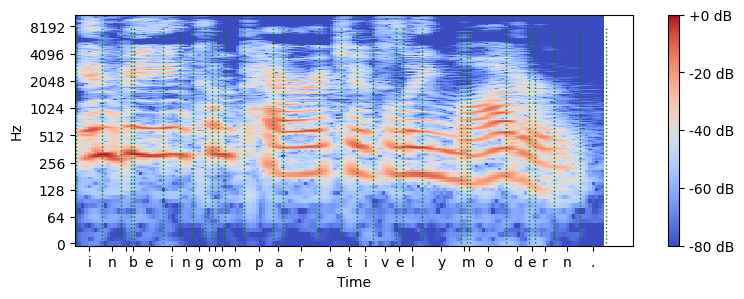

In [49]:
def compute_cumulative_sums(durations):
    out = [0]
    for duration in durations:
        out.append(duration + out[-1])
    return out

def compute_centers(cumulative_sums):
    centers = []
    for index, _ in enumerate(cumulative_sums):
        if index + 1 < len(cumulative_sums):
            centers.append((cumulative_sums[index] + cumulative_sums[index + 1]) / 2)
    return centers

from matplotlib import pyplot as plt

from ttsxai.utils import plot_utils, jupyter_utils

durations_time = durations * mel_step_ms * 0.001

fig, ax = plt.subplots(1, 1, figsize=(9, 3))
plot_utils.plot_spectrogram(wav, sr=sample_rate, spec_type='spectrogram', ax=ax)
ax.vlines(x=compute_cumulative_sums(durations_time), colors="green", linestyles="dotted", ymin=0.0, ymax=8000, linewidth=1.0)
ax.xaxis.grid(True, which='minor')
ax.set_xticks(compute_centers(compute_cumulative_sums(durations_time)), minor=False)
ax.set_xticklabels(text);


In [10]:
# Cut word out of wav
print(text[9:22])
char_time = np.cumsum(np.pad(durations, (1, 0))) * hop_len
wav_start, wav_end = char_time[9], char_time[22]
wav_cut = wav[wav_start: wav_end]
ipd.Audio(wav_cut, rate=sample_rate)

comparatively
